In [1]:
import sys
sys.path.append('./lib/')

with open('./lib/common_imports.py') as f:
    exec(f.read())

from lib.bootstrap import plot_dice, plot_unfair_dice

# The bootstrap and resampling

## The bootstrap

The bootstrap is a tremendously useful tool for constructing confidence intervals and calculating standard errors for difficult statistics. For a classic example, how would one derive a confidence interval for the median? The bootstrap procedure follows from the so called bootstrap principle. 

To illustrate the bootstrap principle, imagine a die roll. The image below shows the mass function of a die roll on the left. On the right we show the empirical distribution obtained by repeatedly averaging 50 independent die rolls. By this simulation, without any mathematics, we have a good idea of what the distribution of averages of 50 die rolls looks like.

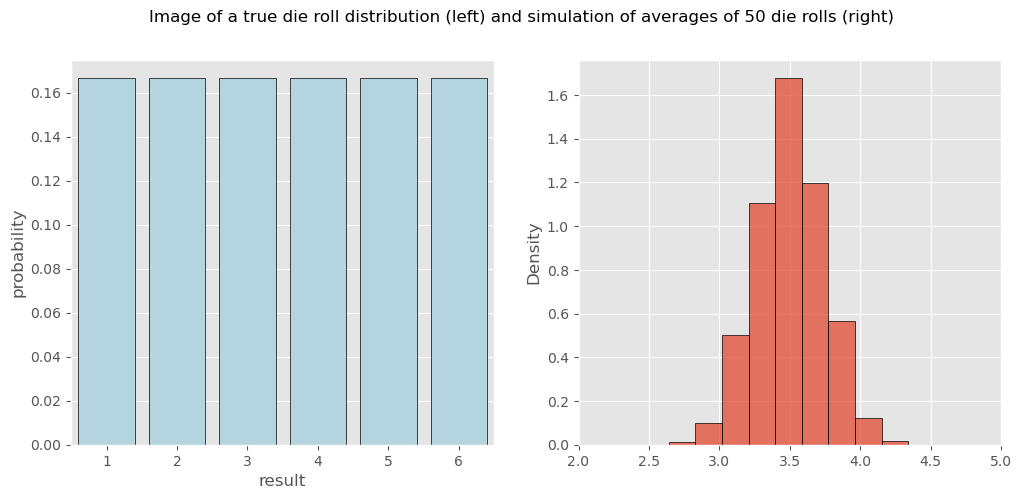

In [2]:
plot_dice(fig_h = 5,
         fig_w=12)

Now imagine a case where we didn’t know whether or not the die was fair. We have a sample of size 50 and we’d like to investigate the distribution of the average of 50 die rolls *where we’re not allowed to roll the die anymore*. This is more like a real data analysis, we only get one sample from the population.

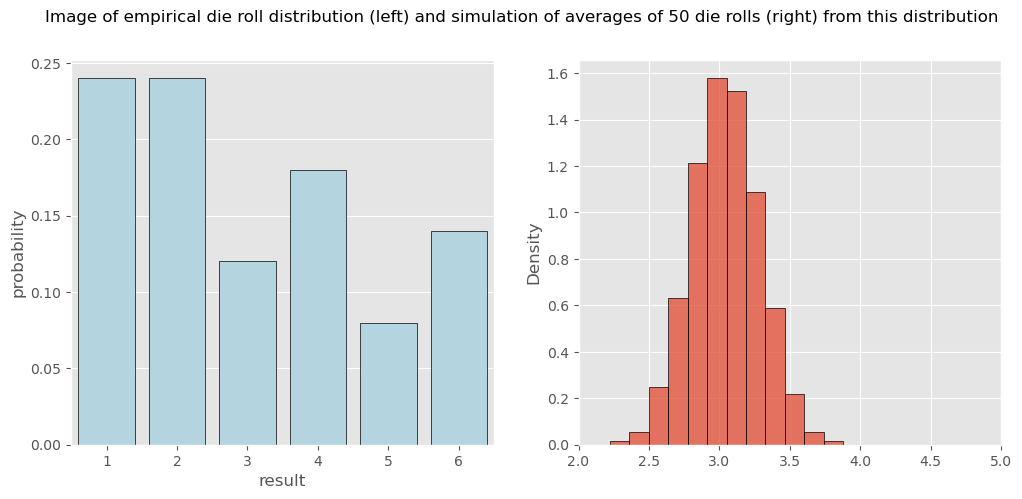

In [3]:
plot_unfair_dice(
    fig_h = 5,
    fig_w=12
)

The bootstrap principle is to use the empirical mass function of the data to perform the simulation, rather than the true distribution. That is, we simulate averages of 50 samples from the histogram that we observe. With enough data, the empirical distribution should be a good estimate of the true distribution and this should result in a good approximation of the sampling distribution.

That’s the bootstrap principle: investigate the sampling distribution of a statistic by simulating repeated realizations from the observed distribution.

If we could simulate from the true distribution, then we would know the exact sampling distribution of our statistic (if we ran our computer long enough.) However, since we only get to sample from that distribution once, we have to be content with using the empirical distribution. This is the clever idea of the bootstrap.

## Example Galton's father and sons dataset

The code below creates resamples via draws of size n with replacement with the original data of the son’s heights from Galton’s data and plots a histogram of the median of each resampled dataset.

In [4]:
x = pd.read_csv('./data/father_son.csv')['sheight']

In [5]:
# numpy.random.choice replace=True by default. Keeping it for clarity
np.random.seed(100)
n = len(x)
B = 10000
t = np.random.choice(x, size = (n, B), replace = True)
resampledMedians = np.median(t, axis=0)

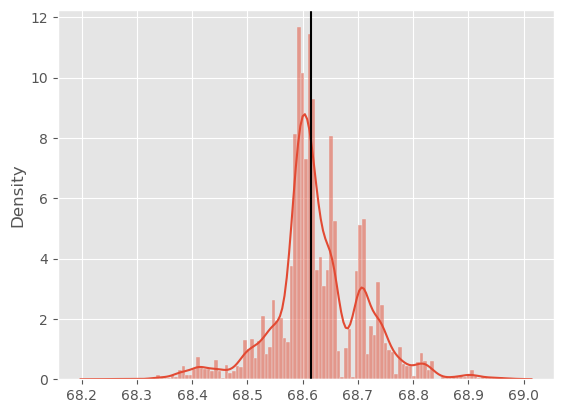

In [6]:
sns.histplot(
    resampledMedians,
    stat='density',
    kde=True
);

plt.axvline(x = x.median(), color = 'k');

## The bootstrap principle

Suppose that I have a statistic that estimates some population parameter, but I don’t know its sampling distribution. The bootstrap principle suggests using the distribution defined by the data to approximate its sampling distribution.

### The bootstrap in practice

In practice, the bootstrap principle is always carried out using simulation. We will cover only a few aspects of bootstrap resampling. The general procedure follows by first simulating complete data sets from the observed data with replacement. This is approximately drawing from the sampling distribution of that statistic, at least as far as the data is able to approximate the true population distribution. Calculate the statistic for each simulated data set Use the simulated statistics to either define a confidence interval or take the standard deviation to calculate a standard error.

### Nonparametric bootstrap algorithm example

Bootstrap procedure for calculating confidence interval for the ***median*** from a data set of $n$ observations:
1. Sample $n$ observations **with replacement** from the observed data resulting in one simulated complete data set.
2. Take the median of the simulated data set
3. Repeat these two steps $B$ times, resulting in $B$ simulated medians
4. These medians are approximately drawn from the sampling distribution of the median of $n$ observations; therefore we can
    - Draw a histogram of them
    - Calculate their standard deviation to estimate the standard error of the median
    - Take the $2.5^{th}$ and $97.5^{th}$ percentiles as a confidence interval for the median
  
For the general bootstrap, just replace the median with whatever statistic that you're investigating

## Example code

Consider our father/son data from before. Here is the relevant code for doing the resampling.

In [7]:
np.random.seed(100)
B = 10000
resamples = np.random.choice(x, size = (n, B), replace = True)
medians = np.median(resamples, axis=0)

In [8]:
np.std(medians, ddof=1)

0.08420822055055778

Thus, $0.084$ estimates the standard error of the median for this data set. It did this by repeatedly sampling medians from the observed distribution and taking the standard deviation of the resulting collection of medians. Taking the $2.5$ and $97.5$ percentiles gives us a bootstrap $95\%$ confidence interval for the median.

In [9]:
np.round(np.quantile(medians, q = [0.025, 0.975]), 2)

array([68.43, 68.81])

We also always want to plot a histogram or density estimate of our simulated statistic.

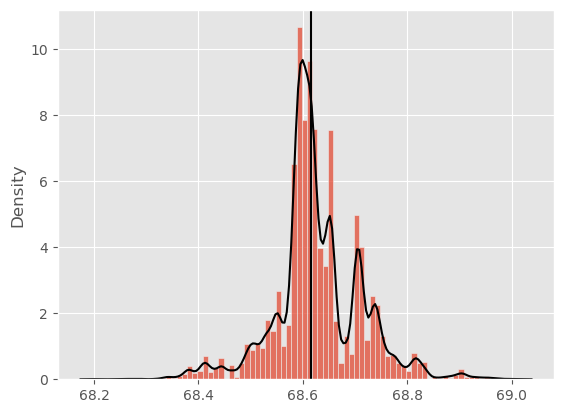

In [10]:
sns.histplot(
    medians,
    stat='density',
    binwidth=0.01,
    kde=False,
#    kde_kws={'bw_adjust': 0.6}
);


sns.kdeplot(medians, 
            bw_adjust=0.6, color="k")

plt.axvline(x = np.median(medians), color = 'k');

## Summary notes on the bootstrap

- The bootstrap is non parametric (Parametric statistics are based on assumptions about the distribution of population from which the sample was taken. Nonparametric statistics are not based on assumptions, that is, the data can be collected from a sample that does not follow a specific distribution).
- Better percentile bootstrap confidence intervals correct for bias.
- There are lots of variations on bootstrap procedures; the book [An Introduction to the Bootstrap](https://www.routledge.com/An-Introduction-to-the-Bootstrap/Efron-Tibshirani/p/book/9780412042317) by Efron and Tibshirani is a great place to start for both bootstrap and jackknife information.

## Group comparisons via permutation tests

Consider comparing two independent groups. Example, comparing sprays B and C

In [11]:
insectsprays = pd.read_csv('./data/InsectSprays.csv')

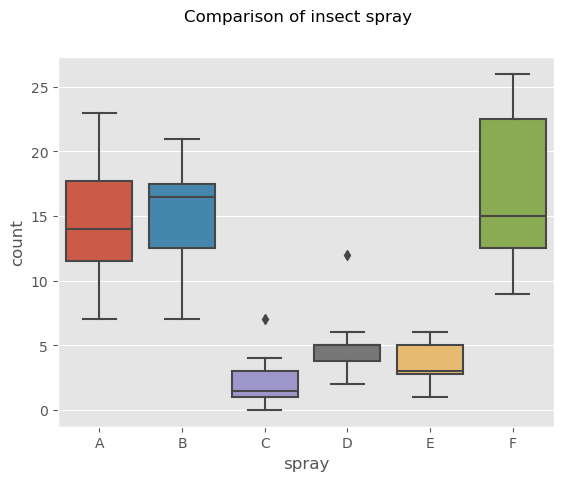

In [12]:
sns.boxplot(
    data = insectsprays,
    y = 'count',
    x = 'spray',
);

plt.suptitle('Comparison of insect spray');

## Permutation tests

Consider comparing means between the group. However, let’s use the calculate the distribution of our statistic under a null hypothesis that the labels are irrelevant (exchangeable). This is a handy way to create a null distribution for our test statistic by simply permuting the labels over and over and seeing how extreme our data are with respect to this permuted distribution.

The procedure would be as follows:
1. consider a data from with count and spray,
2. permute the spray (group) labels,
3. recalculate the statistic (such as the difference in means),
4. calculate the percentage of simulations where the simulated statistic was more extreme
(toward the alternative) than the observed.

### Variations on permutation testing

This idea of exchangeability of the group labels is so powerful, that it’s been reinvented several times in statistic. The table below gives three famous tests that are obtained by permuting group labels.

| Data type | Statistic | Test name |
|:----------|:----------|:----------|
|Ranks | rank sum | rank sum test |
|Binary| hypergeometric prob | Fisher's exact test |
|Raw data | | prermutation test |

Also, so-called ***randomization tests*** are exactly permutation tests, with a different motivation. In that case, think of the permutation test as replicating the random assignment over and over.

For matched or paired data, it wouldn’t make sense to randomize the group labels, since that would break the association between the pairs. Instead, one can randomize the signs of the pairs. For data that has been replaced by ranks, you might of heard of this test before as the ***signed rank test***.

Again we won’t cover more complex examples, but it should be said that permutation strategies work for regression as well by permuting a regressor of interest (though this needs to be done with care). These tests work very well in massively multivariate settings.

### Permutation test B vs C

Let’s create some code for our example. Our statistic will be the difference in the means in each group.

In [13]:
import random

subdata_ = insectsprays[insectsprays['spray'].isin(['B', 'C'])]
subdata = subdata_.copy()

observedStat = subdata[subdata['spray'] == 'B']['count'].mean() - subdata[subdata['spray'] == 'C']['count'].mean()

np.random.seed(100)

permutation = []
for i in np.arange(0, 10000):
    random.shuffle(subdata['spray'].values)
    permutation.append(subdata[subdata['spray'] == 'B']['count'].mean() - subdata[subdata['spray'] == 'C']['count'].mean())

permutation = np.array(permutation)

Let's look at some of the results. First let's look at the observed statistic.

In [14]:
observedStat

13.25

Now, let's see what proportion of times we got a simulated statistic larger than our observed statistic.

In [15]:
(permutation > observedStat).mean()

0.0

Since this is $0$, our estimate of the P-value is $0$ (i.e. we strongly reject the Null). It’s useful to look at a histogram of permuted statistics with a vertical line drawn at the observed test statistic for reference.

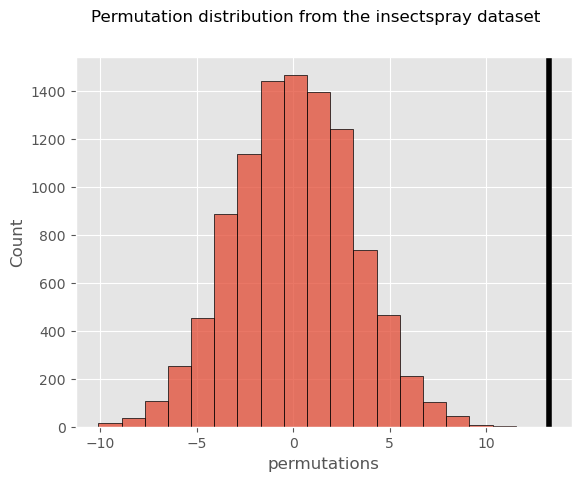

In [16]:
sns.histplot(
    permutation,
    binwidth=1.2,
    ec = 'k',
)


plt.axvline(x = subdata_[subdata_['spray'] == 'B']['count'].mean() - subdata_[subdata_['spray'] == 'C']['count'].mean(), color = 'k', linewidth=4)
plt.xlabel('permutations');
plt.suptitle('Permutation distribution from the insectspray dataset');